In [3]:

import pandas as pd
xlsx_file_path = 'Dev_data_to_be_shared.xlsx'
df = pd.read_excel(xlsx_file_path)

In [ ]:
df

In [ ]:
df

In [4]:
# Apply preprocessing steps
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
# Specify the maximum depth for the decision trees
max_depth = 15

# Initialize the RandomForestClassifier with the specified maximum depth

clf = RandomForestClassifier(max_depth=max_depth,n_estimators=120)

# Load the entire dataset


# Define a function to count the number of repeated continuous values in consecutive transaction columns for each account
def count_repeated_continuous_values(group):
    txn_columns = group.filter(like='txn_')
    count = txn_columns.apply(lambda row: sum(row[i] == row[i+1] and row[i] >200 for i in range(len(row)-1)), axis=1)
    return count.sum()

# Apply the function to each group (account) and create a new column indicating the count of repeated continuous values
def modify_count(count):
    if count < 3:
        return 0
    else:
        return 1


def convert_income_to_numeric(value):
        try:
            if value == "":
                return 1
            elif value == "100001 to 5L":
                return 500000
            elif value == "0 to 1L":
                return 100000
            elif value == "5L to 10L":
                return 1000000
            elif value == "10L to 25L":
                return 2500000
            elif value == "25L to 50L":
                return 5000000
            elif value == 0:
            
                return 1
            elif value == "50L to 3Crore":
                return 30000000
            elif value == "3Crore to 5Crore":
                return 50000000
            elif value == "10Crore to 15Crore":
                return 150000000
            elif value == "5Crore to 10Crore":
                return 100000000
            elif value == "20Crore to 35Crore":
                return 350000000
            elif value == "15Crore to 20Crore":
                return 200000000
            else:
                return int(value)  # Try to convert other values to integers
        except ValueError:
            print(f"Error converting value to numeric: {value}")
            return 1  # Return 0 for values that couldn't be converted
        return value
    
#******
    # Define a function to count repeated non-zero transaction values
def count_repeated_nonzero(row):
    txn_values = row.filter(like='txn_')  # Select columns starting with 'txn_'
    non_zero_values = txn_values[txn_values > 200]  # Select non-zero values
    repeated_non_zero_values = non_zero_values.duplicated().sum()  # Count repeated non-zero values
    return repeated_non_zero_values

def set_ratio_threshold(df):
    # Apply the threshold condition using a lambda function
    df['income_to_transaction_ratio'] = df['income_to_transaction_ratio'].apply(lambda x: 1 if x > 2.5 else 0)
    return df
df.fillna(0, inplace=True)
# Select columns starting with 'txn_'
txn_columns = df.filter(regex='^txn_', axis=1)
# 2. Calculate volume of transaction values
df['volume_transactions'] = (txn_columns != 0).sum(axis=1)

# 3. Determine number of repeated values
df['repeated_values'] = txn_columns.apply(lambda x: len(x) - len(set(x)), axis=1)
# 4. Select features from demog and others
df['count_repeated_continuous_values'] = df.groupby('Primary key').apply(count_repeated_continuous_values)
df['count_repeated_continuous_values'] = df['count_repeated_continuous_values'].apply(modify_count)
# Load your dataset
df['repeated_non_zero_values'] = df.apply(count_repeated_nonzero, axis=1)


In [5]:
# 1. Compute sum of transaction values
df['sum_transactions'] = txn_columns.sum(axis=1)
income_column = 'income'
df[income_column] = df[income_column].apply(convert_income_to_numeric)
  
# Replace count_repeated_continuous_values where it is 0 with the corresponding values of 'demog_3'
df.loc[df['count_repeated_continuous_values'] == 0, 'count_repeated_continuous_values'] = df.loc[df['count_repeated_continuous_values'] == 0, 'demog_3']

df['income_to_transaction_ratio'] =  (df['sum_transactions']*100 ) /( (df['income']*0.75) + 100000)

sum_txn_values_per_city_tier = df.groupby('city_tier')[txn_columns.columns].sum()
# Calculate the average sum of transaction values for each occupation
avg_sum_txn_values_per_city_tier = (sum_txn_values_per_city_tier.mean(axis=1))/800
sum_txn_values_per_occupation = df.groupby('occupation')[txn_columns.columns].sum()
# Calculate the average sum of transaction values for each occupation
avg_sum_txn_values_per_occupation = (sum_txn_values_per_occupation.mean(axis=1))/800
df['Diff_txn_values3'] = df.apply(lambda row: row['sum_transactions'] - avg_sum_txn_values_per_city_tier[row['city_tier']], axis=1) 
df['Diff_txn_values2'] = df.apply(lambda row: row['sum_transactions'] - avg_sum_txn_values_per_occupation[row['occupation']], axis=1) 
df['Diff_txn_values3'] = df['Diff_txn_values3'].apply(lambda x: 1 if x > 14000 else 0)
df['Diff_txn_values2'] = df['Diff_txn_values2'].apply(lambda x: 1 if x > 14000 else 0)
df.loc[df['Diff_txn_values2'] == 0, 'Diff_txn_values2'] = df.loc[df['Diff_txn_values2'] == 0, 'demog_3']
df.loc[df['Diff_txn_values3'] == 0, 'Diff_txn_values3'] = df.loc[df['Diff_txn_values3'] == 0, 'demog_3']

In [ ]:
df


In [45]:
selected_features = ['demog_23', 'demog_20', 'demog_43', 'demog_24', 'demog_40', 'others_12', 'others_6', 'others_13', 'others_9', 'others_7', 'others_15', 'others_16', 'others_10', 'others_25', 'others_21', 'others_23', 'others_24', 'others_22', 'income', 'city_tier', 'sum_transactions', 'volume_transactions', 'repeated_non_zero_values', 'income_to_transaction_ratio', 'Diff_txn_values3', 'Diff_txn_values2']
X_train = df[selected_features]
X_train = pd.get_dummies(X_train)
y_train = df['Target']

# Train the model on the entire dataset
clf = RandomForestClassifier(max_depth=max_depth)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=15)

In [ ]:
len(selected_features)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Assuming you have your dataset loaded into X and y
# X should be your feature matrix and y should be your target variable

# Split the data into training and testing sets
X = df[selected_features]
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns
if not non_numeric_columns.empty:
    print("Non-numeric columns found:", non_numeric_columns)
    # Delete non-numeric columns
    X = X.drop(columns=non_numeric_columns)
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert pandas DataFrames to numpy arrays
X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values


# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define your neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize your neural network
input_size = 23  # Number of features
hidden_size1 = 64
hidden_size2 = 32
output_size = 1  # Binary classification

model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

# Define custom loss function with loss scaling
def custom_loss(outputs, labels):
    scale = torch.where(labels == 0, 1, 1)  # Loss scaling based on class distribution
    loss = nn.BCEWithLogitsLoss(reduction='none')(outputs.squeeze(), labels)
    return torch.mean(loss * scale)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = custom_loss(outputs, labels)  # Use custom loss function
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluate the model on test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs))  # Convert logits to binary predictions
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2f}")


In [59]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Assuming you have your dataset loaded into X and y
# X should be your feature matrix and y should be your target variable

# Split the data into training and testing sets
X = df[selected_features]
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns
if not non_numeric_columns.empty:
    print("Non-numeric columns found:", non_numeric_columns)
    # Delete non-numeric columns
    X = X.drop(columns=non_numeric_columns)
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert pandas DataFrames to numpy arrays
X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values


# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define your neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize your neural network
input_size = 23  # Number of features
hidden_size1 = 128
hidden_size2 = 32
output_size = 1  # Binary classification

model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

# Define custom loss function with loss scaling
def custom_loss(outputs, labels):
    scale = torch.where(labels == 0, 1/70, 1)  # Loss scaling based on class distribution
    loss = nn.BCEWithLogitsLoss(reduction='none')(outputs.squeeze(), labels)
    return torch.mean(loss * scale)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = custom_loss(outputs, labels)  # Use custom loss function
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluate the model on test data
# Initialize counts for correct predictions and total examples for each class
correct_0 = 0
total_0 = 0
correct_1 = 0
total_1 = 0

# Set model to evaluation mode
model.eval()

# Iterate over test data
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs))  # Convert logits to binary predictions
        
        # Update counts for each class
        for pred, true_label in zip(predictions, labels):
            if true_label == 0:
                total_0 += 1
                if pred == true_label:
                    correct_0 += 1
            else:
                total_1 += 1
                if pred == true_label:
                    correct_1 += 1

        # Update total count for accuracy calculation
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

# Calculate test accuracy
accuracy = correct / total
print(f"Overall Test Accuracy: {accuracy:.2f}")

# Calculate accuracy for class 0
accuracy_0 = correct_0 / total_0 if total_0 > 0 else 0
print(f"Accuracy for class 0: {accuracy_0:.2f} (Correct 0s: {correct_0}/{total_0})")

# Calculate accuracy for class 1
accuracy_1 = correct_1 / total_1 if total_1 > 0 else 0
print(f"Accuracy for class 1: {accuracy_1:.2f} (Correct 1s: {correct_1}/{total_1})")



Non-numeric columns found: Index(['demog_43', 'demog_40', 'city_tier'], dtype='object')
Epoch 1/10, Loss: 118.9999
Epoch 2/10, Loss: 62.0610
Epoch 3/10, Loss: 25.8199
Epoch 4/10, Loss: 22.0494
Epoch 5/10, Loss: 18.2553
Epoch 6/10, Loss: 6.6754
Epoch 7/10, Loss: 1.6892
Epoch 8/10, Loss: 5.1583
Epoch 9/10, Loss: 1.7028
Epoch 10/10, Loss: 0.0096
Overall Test Accuracy: 39.49
Accuracy for class 0: 0.88 (Correct 0s: 17342/19614)
Accuracy for class 1: 0.95 (Correct 1s: 368/386)


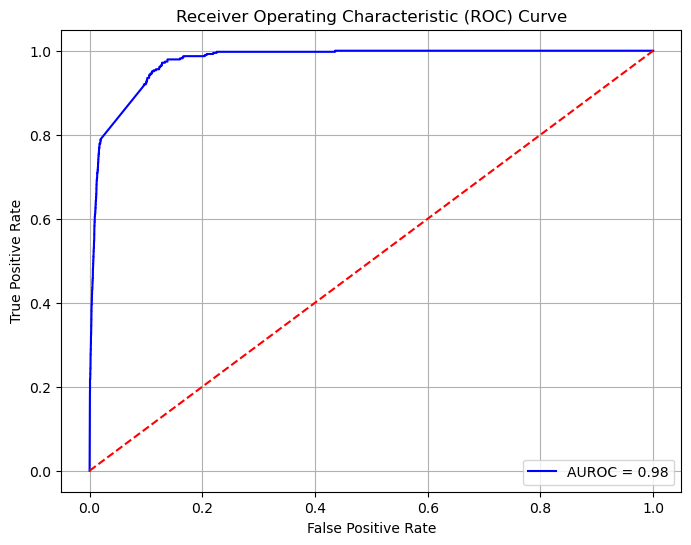

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Initialize lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Make predictions on test data
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted_probs.extend(torch.sigmoid(outputs).squeeze().tolist())  # Convert logits to probabilities
        true_labels.extend(labels.tolist())

# Compute AUROC score
auroc = roc_auc_score(true_labels, predicted_probs)

# Compute ROC curve
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [31]:
# Initialize counts for correct predictions and total examples for each class
correct_0 = 0
total_0 = 0
correct_1 = 0
total_1 = 0

# Set model to evaluation mode
model.eval()

# Iterate over test data
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs))  # Convert logits to binary predictions
        
        # Update counts for each class
        for pred, true_label in zip(predictions, labels):
            if true_label == 0:
                total_0 += 1
                if pred == true_label:
                    correct_0 += 1
            else:
                total_1 += 1
                if pred == true_label:
                    correct_1 += 1

        # Update total count for accuracy calculation
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

# Calculate test accuracy
accuracy = correct / total
print(f"Overall Test Accuracy: {accuracy:.2f}")

# Calculate accuracy for class 0
accuracy_0 = correct_0 / total_0 if total_0 > 0 else 0
print(f"Accuracy for class 0: {accuracy_0:.2f} (Correct 0s: {correct_0}/{total_0})")

# Calculate accuracy for class 1
accuracy_1 = correct_1 / total_1 if total_1 > 0 else 0
print(f"Accuracy for class 1: {accuracy_1:.2f} (Correct 1s: {correct_1}/{total_1})")


Overall Test Accuracy: 62.70
Accuracy for class 0: 1.00 (Correct 0s: 19614/19614)
Accuracy for class 1: 0.00 (Correct 1s: 1/386)


In [22]:
print(len(test_loader)*64)

20032
